# Homework 7: Reservoir simulation
ENVR 890-001: Python for Environmental Research, Fall 2020

By Andrew Hamilton. Some material adapted from Greg Characklis, David Gorelick and H.B. Zeff.

### Summary
In this assignment, we will build on the reservoir simulation example from Lectures 9 & 10. We will perform a Monte Carlo analysis using time series techniques, in order to test different operating rules.

**Due November 23, 2020, by noon,** which is the end of our scheduled exam slot.

### Setup
First load the synthetic streamflow dataset, which we created in Lecture 10. This has 10,000 synthetic time series, each of length 20 years (240 months). Make sure to copy it into the right folder if this homework notebook is located in a different folder than the Lecture 10 notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

synth_inflow = np.loadtxt('synth_inflow.csv', delimiter=',')
print(synth_inflow.shape)
print(synth_inflow)

nsim = synth_inflow.shape[0]
nmonth = synth_inflow.shape[1]

(10000, 240)
[[89929.75824017 91080.22882115 35966.33884626 ... 23147.18749779
  29057.63693227 62048.58570777]
 [55996.3637305  39381.14467834 46121.32173582 ... 13063.45152628
  18460.67033569 25290.56954719]
 [21542.99172946 45714.15056759 47602.3964818  ... 18929.27221569
  12715.9877141  11598.61542107]
 ...
 [52808.47553837 48681.0890656  34038.17717118 ... 12729.13479792
  14294.56794463 13708.69536063]
 [78086.88114493 44462.39703909 86324.12203818 ... 18533.17361729
  14700.23099467 58760.98118021]
 [64822.81765646 92608.47326311 65887.23987938 ... 17702.87396946
  16260.19101644 18295.92642157]]


In [2]:
### other important parameters
storage_max = 4.5e6    ## max storage at shasta is ~4.5 million AF
storage_0 = 3e6   ## let's assume it starts with 3 MAF in storage
demand = 50e3  ## assume demand is 50,000 AF/month
nvar = 4   ## we will store 4 variables each time step: inflow, demand, release, storage

### (1) Baseline operations and demands
**(a)** First, use the basic release function that we used in class (get_release_storage) to simulate the reservoir operations under each of the 10,000 inflow scenarios. Store the inflow, demand, release, and storage at each month. The results should be stored in a 10000x240x4 NumPy array.

**(b)** Create 3 figures: inflow, release, and storage. Each figure should plot the first 10 simulations (s=0 to 9) over the entire 240 months. Include x and y axis labels as well as a legend.

**(c)** Now calculate the following metrics related to water supply and flood risk:
- Supply reliability metric (the fraction of months in which releases are equal to demands.)
- Flood risk metric (the 99.9th percentile of releases.)
- End storage metric (the average storage in the last 12 months of the simulation, as a fraction of max storage.)

### (2) Alternative flood control operations
Very high releases from a reservoir can be very dangerous for flooding. Consider the following alternative set of rules for making releases preemptively when the reservoir is near full:

In [3]:
### function for releases based on demand and max storage capacity
storage_flood = 3e6   ## flood control actions triggered above this storage parameter
fraction_flood = 0.1  ## fraction of water above storage_flood to release

def get_release_storage_floodcontrol(storage_tmin1, storage_max, storage_flood, fraction_flood, inflow, demand):
    release = demand
    storage_t = storage_tmin1 + inflow - release
    if storage_t < 0:                  ### check if storage has gone negative
        release += storage_t
        storage_t = 0
    elif storage_t > storage_flood:    ### check if we want to start drawing down for flood control
        flood_release = (storage_t - storage_flood) * fraction_flood
        release += flood_release
        storage_t -= flood_release
    if storage_t > storage_max:        ### check if storage is still too big, even after flood release
        release += storage_t - storage_max
        storage_t = storage_max
    return release, storage_t

This alternative rule will begin to release extra water when storage nears its maximum, in order to avoid filling up. **Repeat parts a-c from question 1 using this new operating rule. How do the results compare to the situation without flood control?**

### 2nd alternative flood control rule: seasonal drawdown

Text(0.5, 0, 'Month')

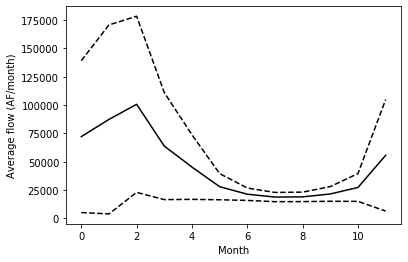

In [4]:
## Notice that the flow is highly seasonal. This can help us from flood control perspective
monthly_mean = np.array([synth_inflow[:, i::12].mean() for i in range(12)])
monthly_std = np.array([synth_inflow[:, i::12].std() for i in range(12)])
plt.plot(monthly_mean, color='k')
plt.plot(monthly_mean + monthly_std, color='k', ls='--')
plt.plot(monthly_mean - monthly_std, color='k', ls='--')

plt.ylabel('Average flow (AF/month)')
plt.xlabel('Month')

In [5]:
### function for releases based on demand and max storage capacity
storage_flood_monthly = [3e6, 3.5e6, 3.75e6, 3.75e6, 3.75e6, 3.5e6, 3.5e6, 3.25e6, 3.25e6, 3.25e6, 3e6, 3e6]   ## flood control actions triggered above this storage parameter
fraction_flood = 0.1  ## fraction of water above storage_flood to release

def get_release_storage_floodcontrol(storage_tmin1, storage_max, storage_flood_monthly, t, fraction_flood, inflow, demand):
    release = demand
    storage_t = storage_tmin1 + inflow - release
    storage_flood = storage_flood_monthly[t % 12]
    if storage_t < 0:
        release += storage_t
        storage_t = 0
    elif storage_t > storage_flood:
        flood_release = (storage_t - storage_flood) * fraction_flood
        release += flood_release
        storage_t -= flood_release
    if storage_t > storage_max:
        release += storage_t - storage_max
        storage_t = storage_max
    return release, storage_t

This flood control rule uses a storage flood parameter that varies throughout the year. This allows us to preemptively release water from the reservoir when the winter/spring floods are coming. **Again repeat parts a-c from question 1 using these flood control rules. How do they compare?**

### (3) Alternative demand scenarios
**(a)**
In addition to uncertainty over inflows, there is considerable uncertainty regarding the future demand for water (we will group all demands together for simplicity, including drinking water supply, irrigation demand, and environmental releases). Let's assume that we have done a study of demand trends and found that the monthly growth rate is likely to be between -0.2% and +0.2% per month. Use the NumPy uniform distribution sampler function (https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to generate 10,000 random values between 0.998 and 1.002.

**(b)** Now rerun the Monte Carlo simulation for the 2nd set of flood control rules, but applying the 10,000 demand growth scenarios along with the 10,000 inflow scenarios (i.e., the first demand growth is matched with the 1st inflow scenario, the 2nd with the 2nd, etc.). **Again repeat steps a-c from question 1.**